In [ ]:
#========================================================================
#
# Name: 01 London House Data.ipynb
#
# Date: 30/09/2025
#
# Author: MT
# 
# Description: London House Data
# https://www.kaggle.com/datasets/oktayrdeki/houses-in-london
#
# Steps:
# Step 0: Imports and Locations
# Step 1: Read Data
# Step 2: Response Variable
# Step 3: Feature Analysis
# Step 4: Feature Importance
# Step 5: Prepare for Modelling
# Step 6: OLS Regression
# Step 7: OLS Regression - Square_Meters interaction
# Step 8: XGBoost Regression
# Step 9: Compare Results
# Step 10: SHAP
#
#========================================================================

In [6]:
#========================================================================
# Step 0: Imports and Locations

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 500) # 10000 columns
pd.set_option('display.max_rows', 500) # 10000 rows

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", font_scale=1.2)

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# XGBoost
from xgboost import XGBRegressor
import xgboost

# SHAP Explainability
import shap
shap.initjs()

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

#------------------------;
def root_mean_squared_error_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RMSE for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(root_mean_squared_error(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RMSE':values})
#------------------------;

#------------------------;
def r2_score_group(y_true=None, y_pred=None, group=None):
    """
    Calculate RSQ for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_pred=y_pred[group==this_level]
        values.append(r2_score(y_true=this_y_true, y_pred=this_y_pred))
    return pd.DataFrame({'group':levels, 'RSQ':values})
#------------------------;
#========================================================================

In [7]:
#========================================================================
# Step 1: Read Data

# Read data
df=pd.read_csv('london_houses.csv')

# Temporary Updates]
df2=copy.deepcopy(df)

# Rename
df2.rename(columns={'Price (£)':'Price'}, inplace=True)

# Log10 Price
df2['log10_Price']= np.log10(df2['Price'])

# train test split 
df2.reset_index(drop=False, inplace=True)
df2.rename(columns={'index':'ID'}, inplace=True)
train_ID, test_ID = train_test_split(df2['ID'], test_size=0.25, random_state=7)
df2['train']=np.where(df2['ID'].isin(train_ID),1,0)

# Final Dataset
df3=copy.deepcopy(df2.drop(columns=['Address', 'log10_Price']))
df3.columns=df3.columns.str.replace(' ', '_')

df3.info()
print('')
#========================================================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               1000 non-null   int64 
 1   Neighborhood     1000 non-null   object
 2   Bedrooms         1000 non-null   int64 
 3   Bathrooms        1000 non-null   int64 
 4   Square_Meters    1000 non-null   int64 
 5   Building_Age     1000 non-null   int64 
 6   Garden           1000 non-null   object
 7   Garage           1000 non-null   object
 8   Floors           1000 non-null   int64 
 9   Property_Type    1000 non-null   object
 10  Heating_Type     1000 non-null   object
 11  Balcony          1000 non-null   object
 12  Interior_Style   1000 non-null   object
 13  View             1000 non-null   object
 14  Materials        1000 non-null   object
 15  Building_Status  1000 non-null   object
 16  Price            1000 non-null   int64 
 17  train            1000 non-null   i

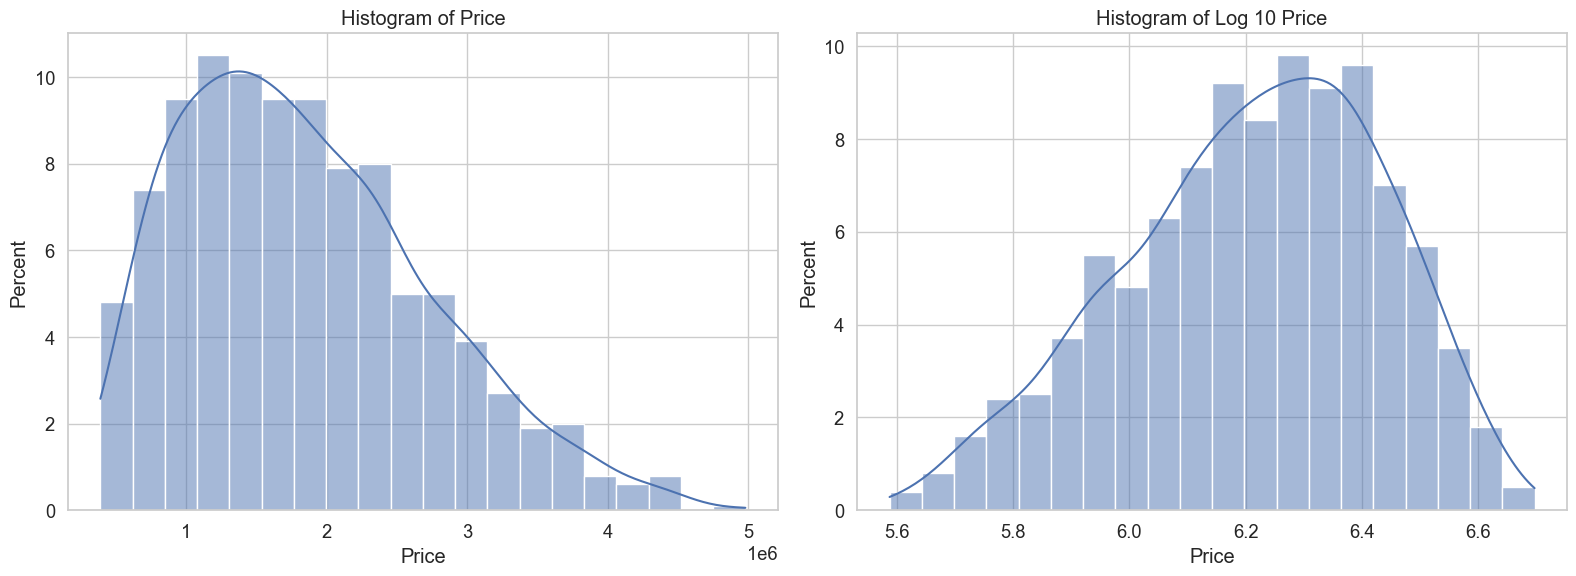

In [20]:
#========================================================================
# Step 2: Response Variable

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of Price
sns.histplot(df2, 
             x='Price', 
             bins=20, 
             stat='percent',
             kde=True,
             ax=axes[0])
axes[0].set_title('Histogram of Price', loc='center')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Percent')

# Histogram of log10 Price
sns.histplot(df2, 
             x='log10_Price', 
             bins=20, 
             stat='percent',
             kde=True,
             ax=axes[1])
axes[1].set_title('Histogram of Log 10 Price', loc='center')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Percent')

plt.tight_layout()
plt.savefig("london-house-price-histogram.png", dpi=300)
plt.show()
#========================================================================


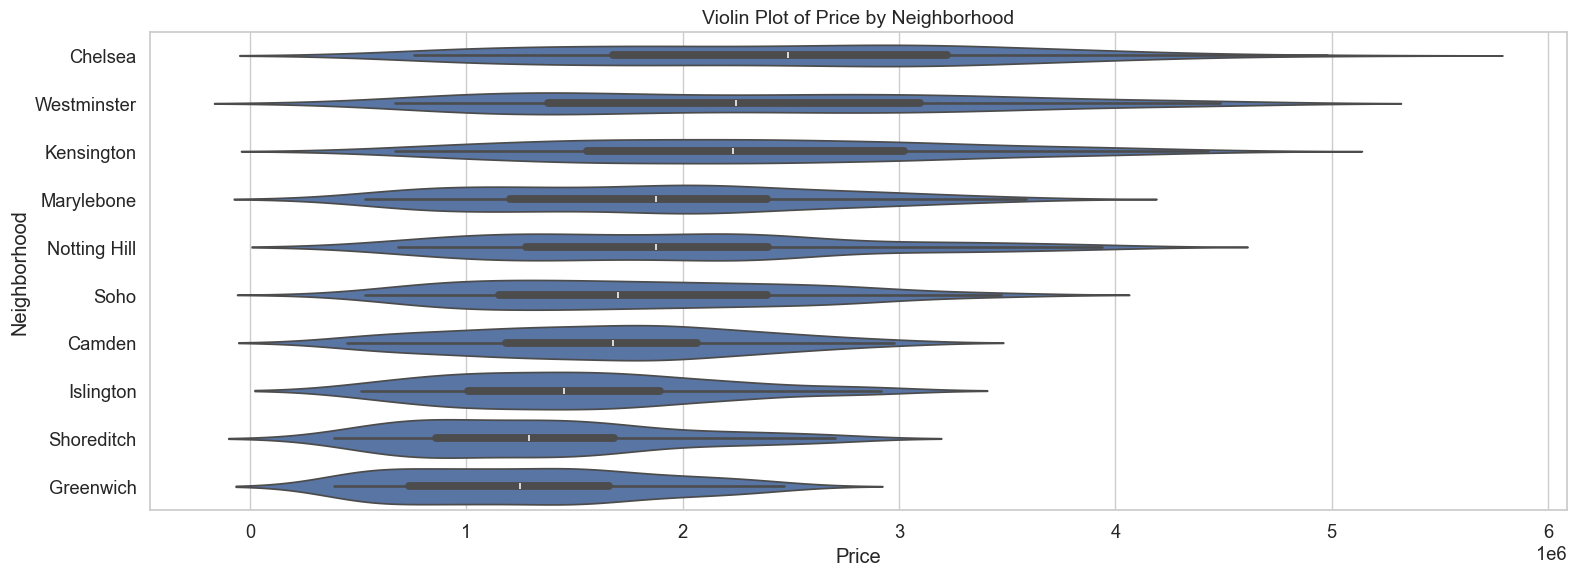

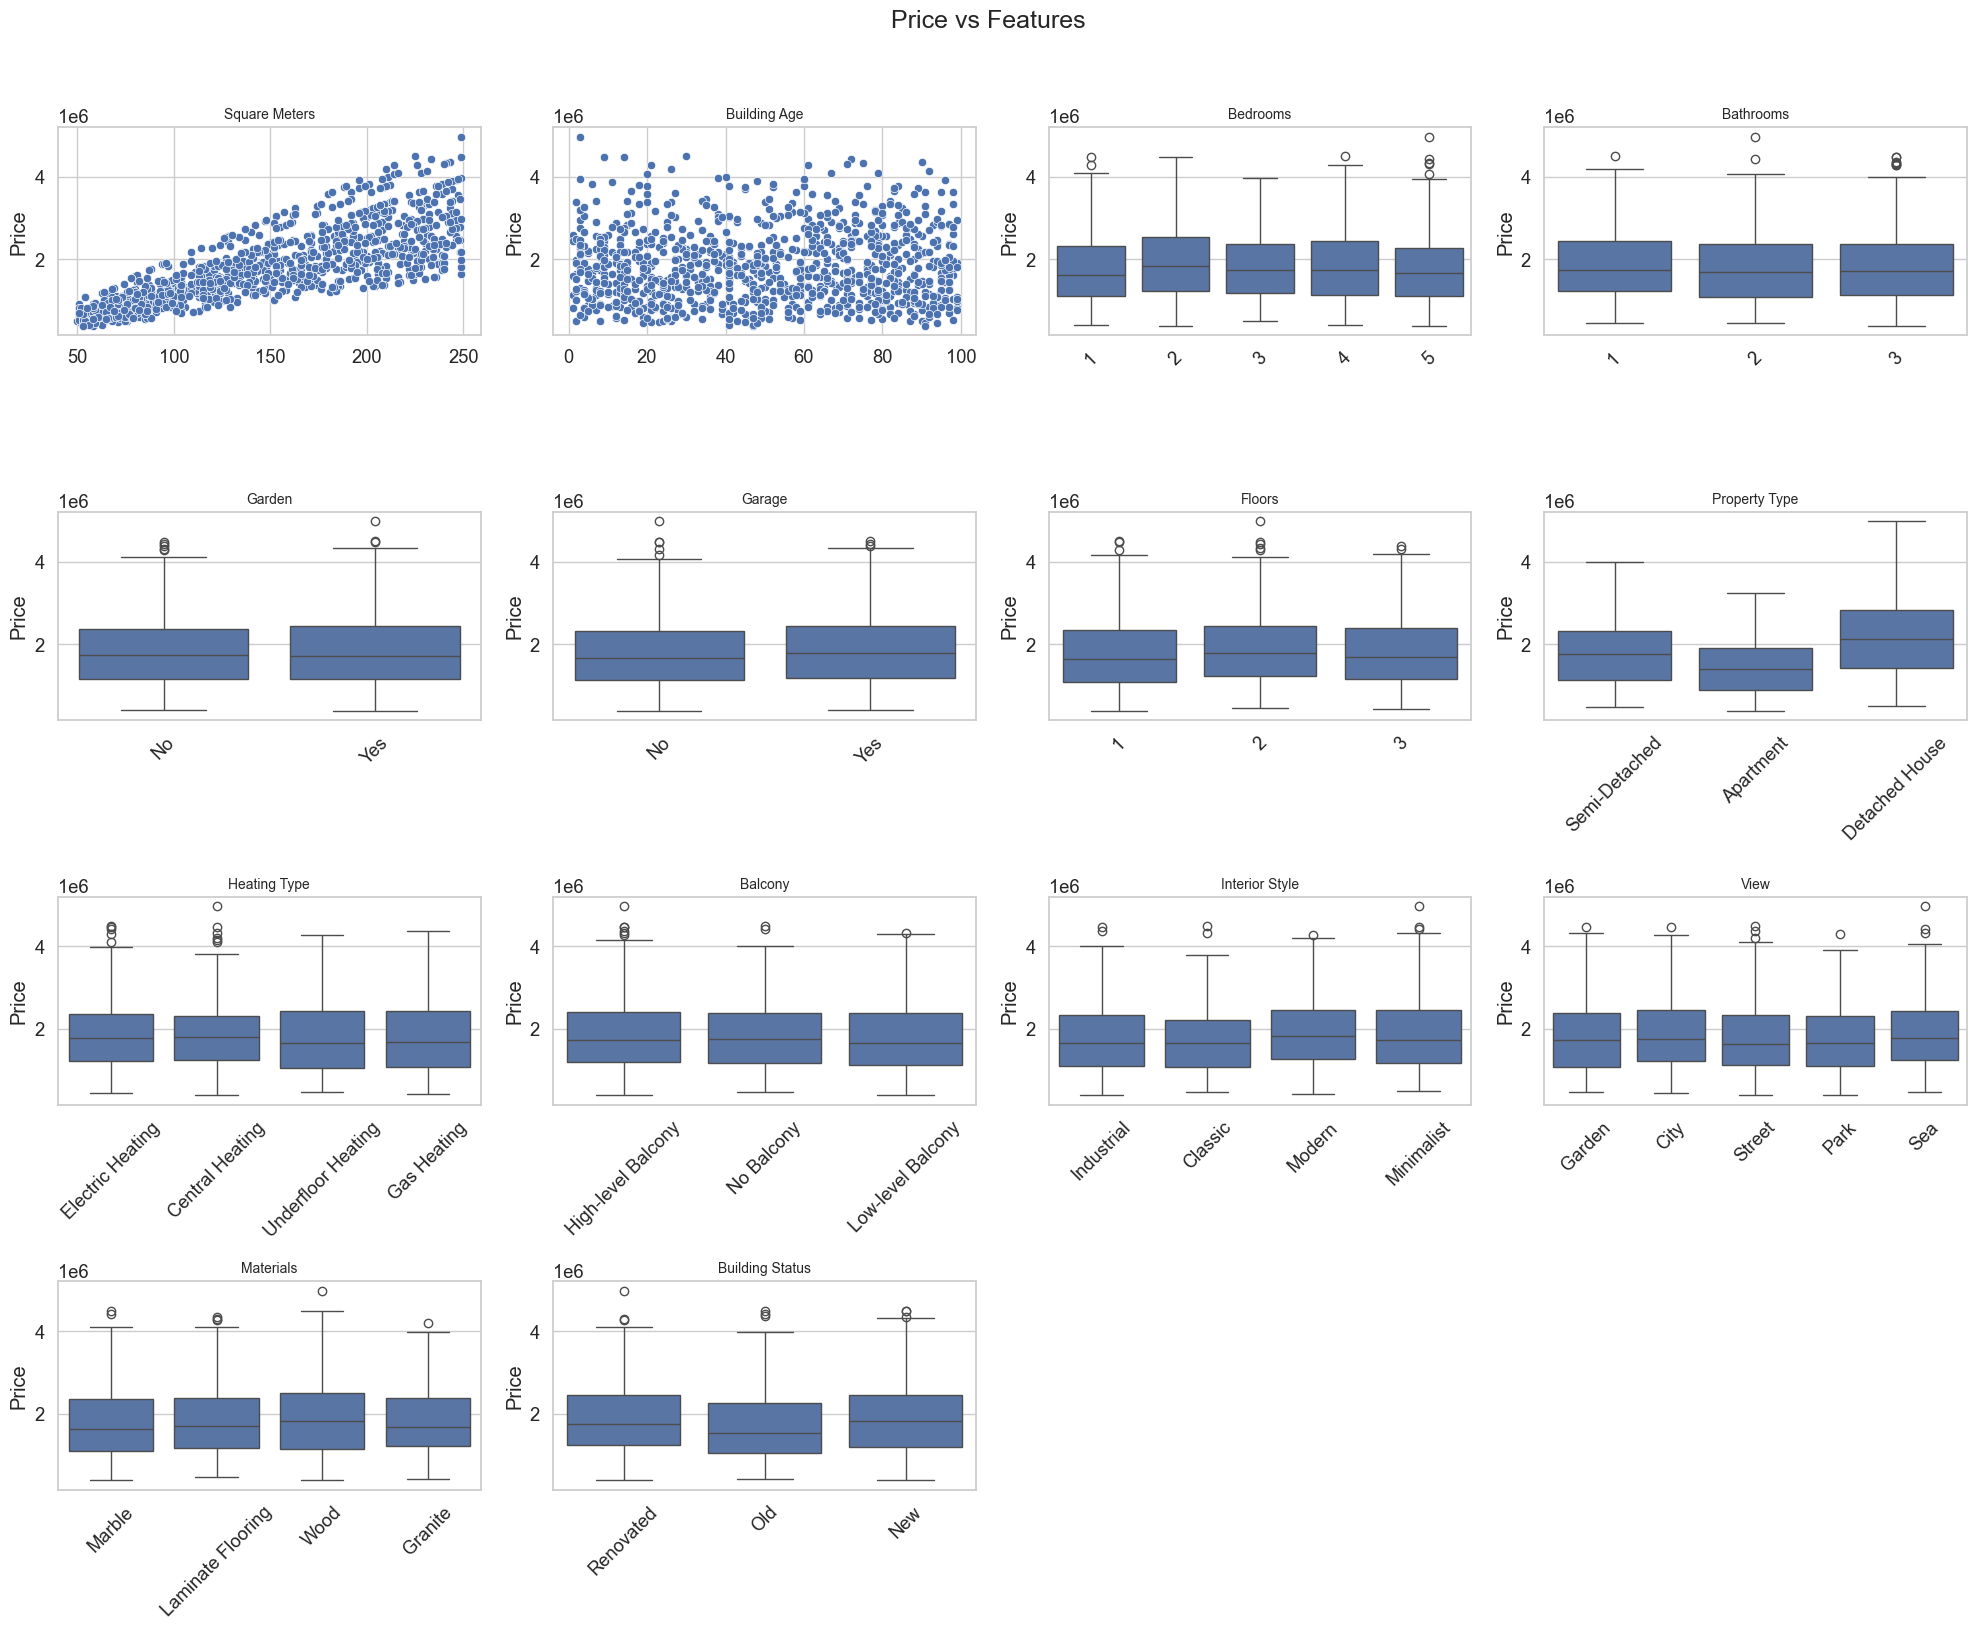

In [21]:
#========================================================================
# Step 3: Feature Analysis

# Neighborhood
Neighborhood_medians=df2[['Neighborhood', 'Price']]\
    .groupby('Neighborhood')\
    .median()\
    .sort_values(by='Price', ascending=False)\
    .reset_index()['Neighborhood'].to_list()

# Plot the violin plot
plt.figure(figsize=(16, 6))
sns.violinplot(
    data=df2,
    y='Neighborhood',
    x='Price',
    order=Neighborhood_medians
)
plt.title('Violin Plot of Price by Neighborhood', fontsize=14, loc='center')
plt.tight_layout()
plt.savefig("london-house-price-neighborhood.png", dpi=300)
plt.show()


# Continuous + Categorical variables
cont_vars = ['Square Meters', 'Building Age']
cat_vars = ['Bedrooms', 'Bathrooms', 'Garden', 'Garage', 'Floors', 'Property Type',
            'Heating Type', 'Balcony', 'Interior Style', 'View', 'Materials', 'Building Status']
all_vars = cont_vars + cat_vars

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, this_var in enumerate(all_vars):
    ax = axes[i]
    if this_var in cont_vars:
        sns.scatterplot(data=df2, x=this_var, y='Price', ax=ax)
        ax.set_title(f'{this_var}', fontsize=10)
    else:
        sns.boxplot(data=df2, x=this_var, y='Price', ax=ax)
        ax.set_title(f'{this_var}', fontsize=10)
        ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel("")
# Remove unused subplots (if any)
for j in range(len(all_vars), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Price vs Features", fontsize=18, y=1.02)
plt.savefig("london-house-price-features.png", dpi=300)
plt.tight_layout()
plt.show()
#=======================================================================

In [22]:
#========================================================================
# Step 4: Feature Importance

# R-Squrared
features=[]
rsq=[]
vars=df3.columns
vars=vars[~vars.isin(['Price', 'ID', 'train'])]
for this_var in vars:
    mdl = smf.ols(formula=f'Price ~ {this_var}', data=df3).fit()
    features.append(this_var)
    rsq.append(mdl.rsquared.round(4))

df_rsq=pd.DataFrame({'Feature':features, 'Rsq':rsq})\
    .sort_values(by='Rsq', ascending=False)\
    .reset_index(drop=True)
df_rsq
#========================================================================

,Feature,Rsq
0,Square_Meters,0.6251
1,Neighborhood,0.1933
2,Property_Type,0.1103
3,Building_Status,0.0088
4,Interior_Style,0.0078
5,Materials,0.0050
6,View,0.0034
7,Garage,0.0022
8,Bathrooms,0.0011
9,Building_Age,0.0010


In [23]:
#========================================================================
# Step 5: Prepare for Modelling

# Create Dummies
df4=pd.get_dummies(df3, dtype='int64')
df4.columns=df4.columns.str.replace(' ', '_')
df4.columns=df4.columns.str.replace('-', '_')

# X and y
X=df4.loc[:,~df4.columns.isin(['ID', 'train', 'Price'])]
y=df4.loc[:,df4.columns=='Price']

# Train-test split
X_train=X.loc[df4.train==1, :]
X_test =X.loc[df4.train==0, :]

y_train=y.loc[df4.train==1, :]
y_test =y.loc[df4.train==0, :]
#========================================================================

In [24]:
#========================================================================
# Step 6: OLS Regression
formula='Price ~ Square_Meters + Neighborhood + Property_Type'
mdl_ols=smf.ols(formula=formula, data=df3.loc[df3.train==1]).fit()
pred_ols=pd.DataFrame({'pred_ols': mdl_ols.predict(df3).round(2)})
print(mdl_ols.summary())
#========================================================================

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1099.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:50:53   Log-Likelihood:                -10233.
No. Observations:                 750   AIC:                         2.049e+04
Df Residuals:                     737   BIC:                         2.055e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [25]:
#========================================================================
# Step 7: OLS Regression - Square_Meters interaction

df3b=copy.deepcopy(df3)
df3b['Square_Meters2']=df3b['Square_Meters']**2

formula='Price ~ Square_Meters + Square_Meters2 + Neighborhood + Property_Type'
mdl_ols2=smf.ols(formula=formula, data=df3b.loc[df3b.train==1]).fit()
pred_ols2=pd.DataFrame({'pred_ols2': mdl_ols2.predict(df3b).round(2)})
print(mdl_ols2.summary())
#========================================================================

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1021.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:50:58   Log-Likelihood:                -10230.
No. Observations:                 750   AIC:                         2.049e+04
Df Residuals:                     736   BIC:                         2.055e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [46]:
#========================================================================
# Step 8: XGBoost Regression
model_xgb = XGBRegressor(
    max_depth=2, 
    min_child_weight=20,
    n_estimators=1000, 
    learning_rate=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    seed=7)
model_xgb.fit(X_train, y_train)
pred_xgb=pd.DataFrame({'pred_xgb': model_xgb.predict(X).round(0)})
#========================================================================

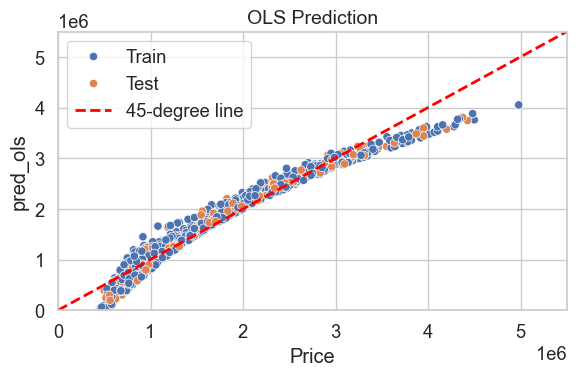

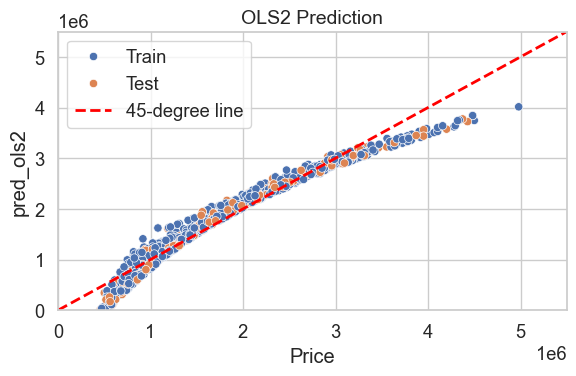

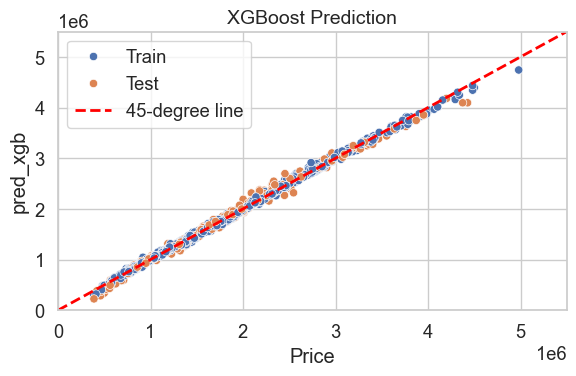

,group,RMSE,Model
0,Train,203923.77,OLS
1,Test,196788.19,OLS
0,Train,203134.76,OLS2
1,Test,200161.57,OLS2
0,Train,41830.42,XGBoost
1,Test,78924.84,XGBoost


,group,RSQ,Model
0,Train,0.9471,OLS
1,Test,0.9471,OLS
0,Train,0.9475,OLS2
1,Test,0.9452,OLS2
0,Train,0.9978,XGBoost
1,Test,0.9915,XGBoost


In [48]:
#========================================================================
# Step 9: Compare Results

# Results
pred=pd.concat([pred_ols, pred_ols2, pred_xgb, df3[['Price', 'train']]], axis=1)
pred['Split']=np.where(pred['train']==1, 'Train', 'Test')

# Scatterplot
def my_graph(this_model=None, this_name=None):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=pred, x='Price', y=this_model, hue='Split', palette='deep')
    plt.plot([0, 5.5E6], [0, 5.5E6], color='red', linestyle='--', linewidth=2, label='45-degree line')
    plt.title(f'{this_name} Prediction', fontsize=14, loc='center')
    plt.xlim(0, 5.5E6)
    plt.ylim(0, 5.5E6)
    plt.xlabel('Price')
    plt.ylabel(this_model)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"london-house-price-{this_name}.png", dpi=300)
    plt.show()

my_graph(this_model='pred_ols', this_name='OLS')
my_graph(this_model='pred_ols2', this_name='OLS2')
my_graph(this_model='pred_xgb', this_name='XGBoost')

# RMSE
a1=root_mean_squared_error_group(y_true=pred['Price'], y_pred=pred['pred_ols'], group=pred['Split']).round(2)
a2=root_mean_squared_error_group(y_true=pred['Price'], y_pred=pred['pred_ols2'], group=pred['Split']).round(2)
a3=root_mean_squared_error_group(y_true=pred['Price'], y_pred=pred['pred_xgb'], group=pred['Split']).round(2)
a1['Model']='OLS'
a2['Model']='OLS2'
a3['Model']='XGBoost'
a4=pd.concat([a1, a2, a3], axis=0)
display(a4)

# RSQ
b1=r2_score_group(y_true=pred['Price'], y_pred=pred['pred_ols'], group=pred['Split']).round(4)
b2=r2_score_group(y_true=pred['Price'], y_pred=pred['pred_ols2'], group=pred['Split']).round(4)
b3=r2_score_group(y_true=pred['Price'], y_pred=pred['pred_xgb'], group=pred['Split']).round(4)
b1['Model']='OLS'
b2['Model']='OLS2'
b3['Model']='XGBoost'
b4=pd.concat([b1, b2, b3], axis=0)
display(b4)
#========================================================================

In [49]:
a4

,group,RMSE,Model
0,Train,203923.77,OLS
1,Test,196788.19,OLS
0,Train,203134.76,OLS2
1,Test,200161.57,OLS2
0,Train,41830.42,XGBoost
1,Test,78924.84,XGBoost


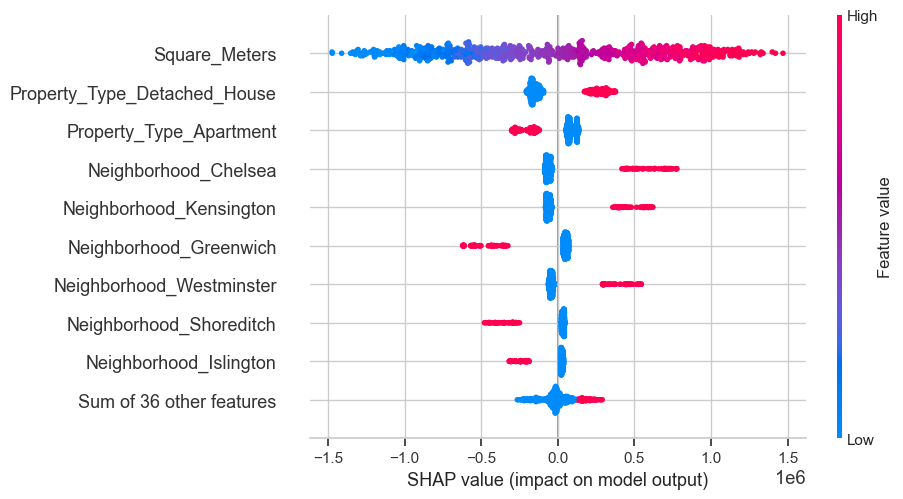

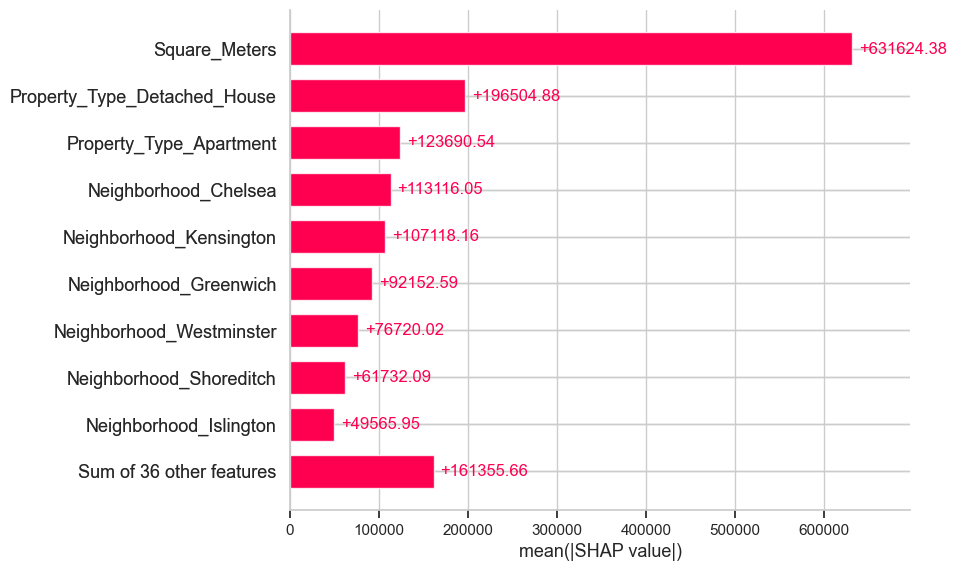

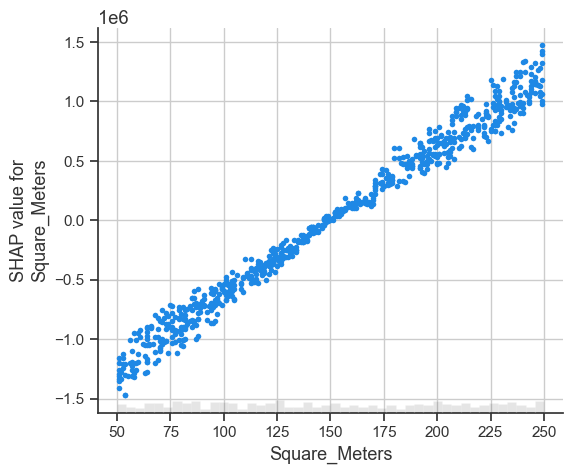

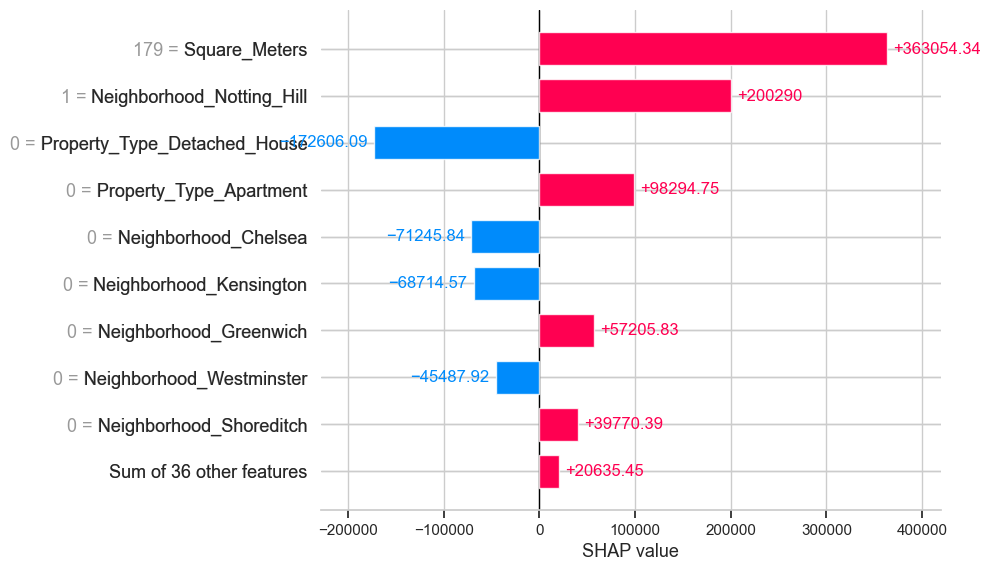

In [28]:
#========================================================================
# Step 10: SHAP

# SHAP Values
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_train)

# Beeswarm
shap.plots.beeswarm(shap_values)

# Feature importance
shap.plots.bar(shap_values)

# Scatter plot
shap.plots.scatter(shap_values[:, "Square_Meters"])

# Waterfall
shap.plots.bar(shap_values[0])

# Force plot
shap.force_plot(shap_values[0])
#========================================================================